**ФИО:** Смольков Максим Дмитриевич

**Группа:** 25152

# **Конвейер для обработки последовательностей**

In [3]:
import numpy as np
import math

Необходимые функции

In [4]:
def dist_levenshtein(seq1, seq2):    
    # Инициализация матрицы
    m, n = len(seq1), len(seq2)
    score_matrix = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    
    # Заполнение первой строки и первого столбца
    for i in range(m + 1):
        score_matrix[i][0] = i
    for j in range(n + 1):
        score_matrix[0][j] = j
    
    # Заполнение матрицы
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # Если символы совпадают, стоимость = 0, иначе 1 (замена)
            match = score_matrix[i-1][j-1] + (0 if seq1[i-1] == seq2[j-1] else 1)
            delete = score_matrix[i-1][j] + 1
            insert = score_matrix[i][j-1] + 1
            
            # Выбор минимального значения
            score_matrix[i][j] = min(match, delete, insert)
       
    return score_matrix[m][n]


def needleman_wunsch(seq1, seq2, match_score=1, mismatch=-1, gap=-1):    
    # Инициализация матрицы
    m, n = len(seq1), len(seq2)
    score_matrix = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    
    # Заполнение первой строки и первого столбца
    for i in range(m + 1):
        score_matrix[i][0] = i * gap
    for j in range(n + 1):
        score_matrix[0][j] = j * gap
    
    # Заполнение матрицы
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # Вычисление трех возможных значений
            match = score_matrix[i-1][j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch)
            delete = score_matrix[i-1][j] + gap
            insert = score_matrix[i][j-1] + gap
            
            # Выбор максимального значения
            score_matrix[i][j] = max(match, delete, insert)
    
    # Обратный ход
    aligned_seq1 = ""
    aligned_seq2 = ""
    alignment_line = ""
    
    i, j = m, n
    while i > 0 or j > 0:
        if i > 0 and j > 0 and score_matrix[i][j] == score_matrix[i-1][j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch):
            # Диагональный переход (совпадение или несовпадение)
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            if seq1[i-1] == seq2[j-1]:
                alignment_line = "|" + alignment_line
            else:
                alignment_line = "*" + alignment_line
            i -= 1
            j -= 1
        elif i > 0 and score_matrix[i][j] == score_matrix[i-1][j] + gap:
            # Вертикальный переход (гэп во второй последовательности)
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = "-" + aligned_seq2
            alignment_line = " " + alignment_line
            i -= 1
        else:
            # Горизонтальный переход (гэп в первой последовательности)
            aligned_seq1 = "-" + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            alignment_line = " " + alignment_line
            j -= 1
    
    return aligned_seq1, alignment_line, aligned_seq2, score_matrix[m][n]


def find_min_pair(D):
    n = len(D)
    min_val = np.inf
    min_pair = (0, 0)
    for i in range(n):
        for j in range(i + 1, n):
            if D[i, j] < min_val:
                min_val = D[i, j]
                min_pair = (i, j)
    return min_pair


def WPGMA(matrix, labels):
    n = len(matrix)
    D = np.array(matrix, dtype=float)

    # Высоты кластеров
    heights = {label: 0 for label in labels}
    cluster_indices = [[i] for i in range(n)]
    order = []

    # Алгоритм
    while len(D) > 1:
        # Находим два ближайших кластера
        i, j = find_min_pair(D)
        order.append((cluster_indices[i], cluster_indices[j]))
        ci, cj = labels[i], labels[j]
        dist = D[i, j] / 2

        # Создаем новое имя в формате Newick
        new_label = f"({ci}:{dist - heights[ci]}, {cj}:{dist - heights[cj]})"
        heights[new_label] = dist
        
        # Новый кластер - объединение индексов
        new_cluster = cluster_indices[i] + cluster_indices[j]

        # Вычисляем новое расстояние до других кластеров
        new_row = (D[i, :] + D[j, :]) / 2
        new_row = np.delete(new_row, [i, j])

        # Обновляем матрицу расстояний
        D = np.delete(D, [i, j], axis=0)
        D = np.delete(D, [i, j], axis=1)
        D = np.vstack((D, new_row))
        new_col = np.append(new_row, [0.0])
        D = np.column_stack((D, new_col))

        # Обновляем метки
        labels = [lab for k, lab in enumerate(labels) if k not in (i, j)] + [new_label]
        newick_str = labels[0]
        cluster_indices = [idx for k, idx in enumerate(cluster_indices) if k not in (i, j)] + [new_cluster]

    return newick_str, order


def k2p_distance(seq1: str, seq2: str) -> float:
    """
    Вычисляет расстояние Кимуры 2-параметра между двумя последовательностями.
    
    Args:
        seq1: Первая последовательность
        seq2: Вторая последовательность
        
    Returns:
        Расстояние Кимуры 2-параметра
    """
    if len(seq1) != len(seq2):
        raise ValueError("Последовательности должны иметь одинаковую длину")
    
    # Определяем пурины и пиримидины
    purines = {'A', 'G'}
    pyrimidines = {'C', 'T', 'U'}  # U для РНК
    
    # Счетчики
    transitions = 0  # транзиции: A↔G, C↔T
    transversions = 0  # трансверсии: A/G ↔ C/T
    total = 0  # общее количество сравненных позиций
    
    for n1, n2 in zip(seq1, seq2):
        # Пропускаем гэпы и неопределенные нуклеотиды
        if n1 == '-' or n2 == '-' or n1 == 'N' or n2 == 'N':
            continue
        
        if n1 == n2:
            total += 1
            continue
        
        total += 1
        
        # Определяем тип замены
        if (n1 in purines and n2 in purines) or (n1 in pyrimidines and n2 in pyrimidines):
            # Транзиция (внутри одного типа)
            transitions += 1
        else:
            # Трансверсия (между типами)
            transversions += 1
    
    if total == 0:
        return 0.0
    
    # Вычисляем доли
    P = transitions / total
    Q = transversions / total
    
    # Формула Кимуры 2-параметра
    # d = -1/2 * ln(1 - 2P - Q) - 1/4 * ln(1 - 2Q)
    
    # Проверяем, чтобы аргументы логарифмов были положительными
    term1 = 1 - 2*P - Q
    term2 = 1 - 2*Q
    
    if term1 <= 0 or term2 <= 0:
        # Если аргументы неположительные, используем Jukes-Cantor как запасной вариант
        # или возвращаем большое расстояние
        diff_sites = transitions + transversions
        p = diff_sites / total if total > 0 else 0
        if p >= 0.75:
            return float('inf')
        return -0.75 * math.log(1 - (4/3) * p)
    
    d = -0.5 * math.log(term1) - 0.25 * math.log(term2)
    
    return d


def profile_score(col1, col2, W):
    freq1 = {}
    freq2 = {}
    n1 = len(col1)
    n2 = len(col2)
    
    if n1 == 0 or n2 == 0:
        return 0
    
    for c in col1:
        if c not in freq1:
            freq1[c] = 0
        freq1[c] += 1
        
    for c in col2:
        if c not in freq2:
            freq2[c] = 0
        freq2[c] += 1

    score = 0
    for a, fa in freq1.items():
        for b, fb in freq2.items():
            score += (fa/n1) * (fb/n2) * W[a][b]

    return score


def needleman_wunsch_profiles(profile1, profile2, W, gap):

    n = len(profile1[0]) + 1  # длина первой последовательности
    m = len(profile2[0]) + 1  # длина второй последовательности

    # создаем матрицы
    score_matrix = [[0] * m for _ in range(n)]
    traceback = [[None] * m for _ in range(n)]

    # инициализация первой строки и столбца
    for i in range(1, n):
        score_matrix[i][0] = i * gap
        traceback[i][0] = 'up'
    for j in range(1, m):
        score_matrix[0][j] = j * gap
        traceback[0][j] = 'left'
    traceback[0][0] = '-'

    # прямой путь
    for i in range(1, n):
        for j in range(1, m):
            # столбцы профилей
            col1 = [seq[i-1] for seq in profile1]
            col2 = [seq[j-1] for seq in profile2]
            
            diag_score = score_matrix[i-1][j-1] + profile_score(col1, col2, W)
            up_score = score_matrix[i-1][j] + gap
            left_score = score_matrix[i][j-1] + gap

            max_score = max(diag_score, up_score, left_score)
            score_matrix[i][j] = max_score

            if diag_score == max_score:
                traceback[i][j] = 'diag'
            elif up_score == max_score:
                traceback[i][j] = 'up'
            else:
                traceback[i][j] = 'left'

    # обратный путь: строим выравненный профиль
    align1 = ['' for _ in profile1]
    align2 = ['' for _ in profile2]
    i, j = n - 1, m - 1

    while i>0 or j>0:
        move = traceback[i][j]
        if move == 'diag':
            for idx, seq in enumerate(profile1):
                align1[idx] += seq[i-1]
            for idx, seq in enumerate(profile2):
                align2[idx] += seq[j-1]
            i -= 1
            j -= 1
        elif move == 'up':
            for idx, seq in enumerate(profile1):
                align1[idx] += seq[i-1]
            for idx in range(len(profile2)):
                align2[idx] += '-'
            i -= 1
        elif move == 'left':
            for idx in range(len(profile1)):
                align1[idx] += '-'
            for idx, seq in enumerate(profile2):
                align2[idx] += seq[j-1]
            j -= 1

    # переворачиваем строки, потому что строились с конца
    align1 = [''.join(reversed(s)) for s in align1]
    align2 = [''.join(reversed(s)) for s in align2]

    # объединяем два профиля
    new_profile = align1 + align2
    return score_matrix, new_profile


def multiple_sequence_alignment(sequences, organisms, alignment_steps, W, gap=-1):
    # Функция множественного выравнивания последовательностей sequences (['ATG','ACG',...]) 
    # по порядку alignment_steps [([0], [2]), ([1], [0, 2]), ([3], [1, 0, 2]), ([4], [3, 1, 0, 2])]
    # organisms - список названий организмов, соответствующих sequences
    
    # Инициализируем кластеры: каждый - набор индексов, профиль и список организмов
    clusters = [{'indices': {i}, 'profile': [sequences[i]], 'organisms': [organisms[i]]} for i in range(len(sequences))]
    
    for step in alignment_steps:
        g1_inds, g2_inds = step
        
        # Находим кластеры, соответствующие группам
        cluster1 = next(c for c in clusters if c['indices'] == set(g1_inds))
        cluster2 = next(c for c in clusters if c['indices'] == set(g2_inds))
        
        prof1 = cluster1['profile']
        prof2 = cluster2['profile']
        
        # Выравниваем профили
        _, new_profile = needleman_wunsch_profiles(prof1, prof2, W, gap)
        
        # Создаем новый кластер с объединенными индексами, профилем и организмами
        new_cluster = {
            'indices': cluster1['indices'] | cluster2['indices'], 
            'profile': new_profile,
            'organisms': cluster1['organisms'] + cluster2['organisms']
        }
        
        # Удаляем старые кластеры
        clusters.remove(cluster1)
        clusters.remove(cluster2)
        
        # Добавляем новый
        clusters.append(new_cluster)
    
    # В итоге остается один кластер
    final_cluster = clusters[0]
    
    # Возвращаем словарь {организм: выровненная_последовательность}
    return dict(zip(final_cluster['organisms'], final_cluster['profile']))


def blosum_to_nested(blosum, gap_score=-1):
    symbols = set()
    for a, b in blosum:
        symbols.add(a)
        symbols.add(b)

    symbols = sorted(symbols)
    symbols.append('-')
    W = {a: {} for a in symbols}

    for a in symbols:
        for b in symbols:
            if a == '-' or b == '-':
                W[a][b] = gap_score
            elif (a, b) in blosum:
                W[a][b] = blosum[(a, b)]
            elif (b, a) in blosum:
                W[a][b] = blosum[(b, a)]
                
    return W


import numpy as np
from typing import Tuple

def jukes_cantor_distance(seq1: str, seq2: str):
    """
    Вычисляет расстояние Джукса-Кантора между двумя аминокислотными последовательностями.
    
    Параметры:
    -----------
    seq1, seq2 : str
        Аминокислотные последовательности одинаковой длины.
    
    Возвращает:
    -----------
    tuple: (p_distance, jc_distance, variance)
        p_distance : float
            Простое p-расстояние (доля различных сайтов)
        jc_distance : float
            Расстояние Джукса-Кантора
        variance : float
            Дисперсия расстояния Джукса-Кантора
    
    Примечания:
    -----------
    - Возвращает (np.nan, np.nan, np.nan) если последовательности разной длины
    - Возвращает (np.nan, np.nan, np.nan) если p_distance >= 0.75 (максимальное значение для JC)
    """
    
    # Проверка одинаковой длины
    if len(seq1) != len(seq2):
        print("Ошибка: последовательности должны быть одинаковой длины")
        return np.nan, np.nan, np.nan
    
    length = len(seq1)
    if length == 0:
        return np.nan, np.nan, np.nan
    
    # Подсчет различий
    differences = 0
    valid_sites = 0
    
    for aa1, aa2 in zip(seq1.upper(), seq2.upper()):
        # Пропускаем гаплы (пробелы, дефисы) и невалидные символы
        if aa1 in '-. ?' or aa2 in '-. ?':
            continue
        
        valid_sites += 1
        if aa1 != aa2:
            differences += 1
    
    # Если нет валидных сайтов
    if valid_sites == 0:
        return np.nan, np.nan, np.nan
    
    # Вычисление p-расстояния
    p = differences / valid_sites
    
    # Проверка на предельное значение
    if p >= 0.75:
        print(f"Предупреждение: p-расстояние ({p:.4f}) >= 0.75, расстояние Джукса-Кантора не определено")
        return p, np.nan, np.nan
    
    # Вычисление расстояния Джукса-Кантора
    # Для аминокислот обычно используется коэффициент 0.95 вместо 3/4 для нуклеотидов
    # Но классическая формула Джукса-Кантора для аминокислот:
    b = 19.0/20.0  # для модели с равными частотами аминокислот
    
    if p > 0 and p < (b - 1e-10):
        jc_distance = -b * np.log(1 - p/b)
    else:
        jc_distance = 0
    
    # Вычисление дисперсии (по Kimura & Ohta, 1972)
    if p > 0 and p < (b - 1e-10):
        variance = (p * (1 - p)) / (valid_sites * (1 - p/b)**2)
    else:
        variance = np.nan
    
    return p, jc_distance, variance

Шаг 1

In [5]:
def parse_sequence_file(filename):
    organisms = []
    amino_acids = []
    nucleotides = []
    
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            
            i = 0
            while i < len(lines):
                line = lines[i].strip()
                
                # Если строка начинается с '>', это название организма
                if line.startswith('>'):
                    organism_name = line[1:].strip()  # Убираем '>' и лишние пробелы
                    organisms.append(organism_name)
                    
                    # Следующая строка - аминокислотная последовательность
                    if i + 1 < len(lines):
                        aa_seq = lines[i + 1].strip()
                        amino_acids.append(aa_seq)
                    
                    # Через одну строку - нуклеотидная последовательность
                    if i + 2 < len(lines):
                        nt_seq = lines[i + 2].strip()
                        nucleotides.append(nt_seq)
                    
                    i += 3  # Переходим к следующему блоку
                else:
                    i += 1  # Пропускаем строки без '>'
                    
    except FileNotFoundError:
        print(f"Ошибка: Файл '{filename}' не найден")
        return [], [], []
    except Exception as e:
        print(f"Ошибка при чтении файла: {e}")
        return [], [], []
    
    return organisms, amino_acids, nucleotides


In [6]:
organisms, amino_acids, nucleotides = parse_sequence_file('long.txt')

Шаг 2

In [7]:
def levenshtein_matrix(sequences):
    n = len(sequences)
    D = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = dist_levenshtein(sequences[i], sequences[j])
            D[i, j] = dist
            D[j, i] = dist
    
    return D

In [8]:
dist_matrix = levenshtein_matrix(nucleotides)

Шаг 3

In [9]:
align_steps = WPGMA(dist_matrix, organisms)[1]

In [10]:
align_steps

[([6], [8]),
 ([0], [1]),
 ([4], [6, 8]),
 ([2], [3]),
 ([0, 1], [2, 3]),
 ([7], [4, 6, 8]),
 ([9], [7, 4, 6, 8]),
 ([0, 1, 2, 3], [9, 7, 4, 6, 8]),
 ([5], [0, 1, 2, 3, 9, 7, 4, 6, 8])]

Шаг 4. Множественное выравнивание

In [11]:
from blosum62 import blosum62
W = {
    'A':{'A':1,'C':-1,'G':-1,'T':-1,'-':-1},
    'C':{'A':-1,'C':1,'G':-1,'T':-1,'-':-1},
    'G':{'A':-1,'C':-1,'G':1,'T':-1,'-':-1},
    'T':{'A':-1,'C':-1,'G':-1,'T':1,'-':-1},
    '-':{'A':-1,'C':-1,'G':-1,'T':-1,'-':-1}
}
blosum_new = blosum_to_nested(blosum62)

msa_nt = multiple_sequence_alignment(nucleotides, organisms, align_steps, W)
msa_aa = multiple_sequence_alignment(amino_acids, organisms, align_steps, blosum_new)

In [12]:
msa_nt_list = []
msa_aa_list = []
for _, seq in msa_nt.items():
    msa_nt_list.append(seq)
for _, seq in msa_aa.items():
    msa_aa_list.append(seq)

Шаг 5. 

In [13]:
def remove_gapped_columns(aligned_sequences):
    """
    Удаляет все колонки, где есть хотя бы один '-'
    Возвращает очищенные последовательности (без гэпов вообще)
    """
    if not aligned_sequences:
        return []
    
    length = len(aligned_sequences[0])
    n = len(aligned_sequences)
    
    cleaned = [""] * n
    
    for col in range(length):
        column = [aligned_sequences[i][col] for i in range(n)]
        if '-' not in column:  # только если ни одного гэпа
            for i in range(n):
                cleaned[i] += column[i]
    
    return cleaned


cleaned_seqs_nt = remove_gapped_columns(msa_nt_list)
cleaned_seqs_aa = remove_gapped_columns(msa_aa_list)

Шаг 6. Построение матрицы расстояния Кимуры и Джукса-Кантора

In [14]:
import math

def k2p_matrix(sequences):
    n = len(sequences)
    D = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = k2p_distance(sequences[i], sequences[j])
            D[i, j] = dist
            D[j, i] = dist
    
    return D


def jc_matrix(seqs):
    n = len(seqs)
    D = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            _, dist, _ = jukes_cantor_distance(seqs[i], seqs[j])
            D[i, j] = dist
            D[j, i] = dist
    
    return D

k2p_dist_matrix_nt = k2p_matrix(cleaned_seqs_nt)
jc_dist_matrix_aa = jc_matrix(cleaned_seqs_aa)

In [15]:
jc_dist_matrix_aa

array([[0.        , 0.05225882, 0.07033739, 0.07033739, 0.08876667,
        0.18669057, 0.08876667, 0.07033739, 0.10756056, 0.10756056],
       [0.05225882, 0.        , 0.01710217, 0.01710217, 0.03451788,
        0.18669057, 0.07033739, 0.05225882, 0.08876667, 0.08876667],
       [0.07033739, 0.01710217, 0.        , 0.01710217, 0.03451788,
        0.18669057, 0.07033739, 0.05225882, 0.08876667, 0.08876667],
       [0.07033739, 0.01710217, 0.01710217, 0.        , 0.01710217,
        0.16628162, 0.05225882, 0.03451788, 0.07033739, 0.07033739],
       [0.08876667, 0.03451788, 0.03451788, 0.01710217, 0.        ,
        0.16628162, 0.05225882, 0.05225882, 0.08876667, 0.08876667],
       [0.18669057, 0.18669057, 0.18669057, 0.16628162, 0.16628162,
        0.        , 0.16628162, 0.12673377, 0.14630191, 0.14630191],
       [0.08876667, 0.07033739, 0.07033739, 0.05225882, 0.05225882,
        0.16628162, 0.        , 0.05225882, 0.08876667, 0.08876667],
       [0.07033739, 0.05225882, 0.0522588

Шаг 7. Построение дерева на основе UPGMA

In [16]:
newick_nt = WPGMA(k2p_dist_matrix_nt, organisms)[0]
newick_aa = WPGMA(jc_dist_matrix_aa, organisms)[0]

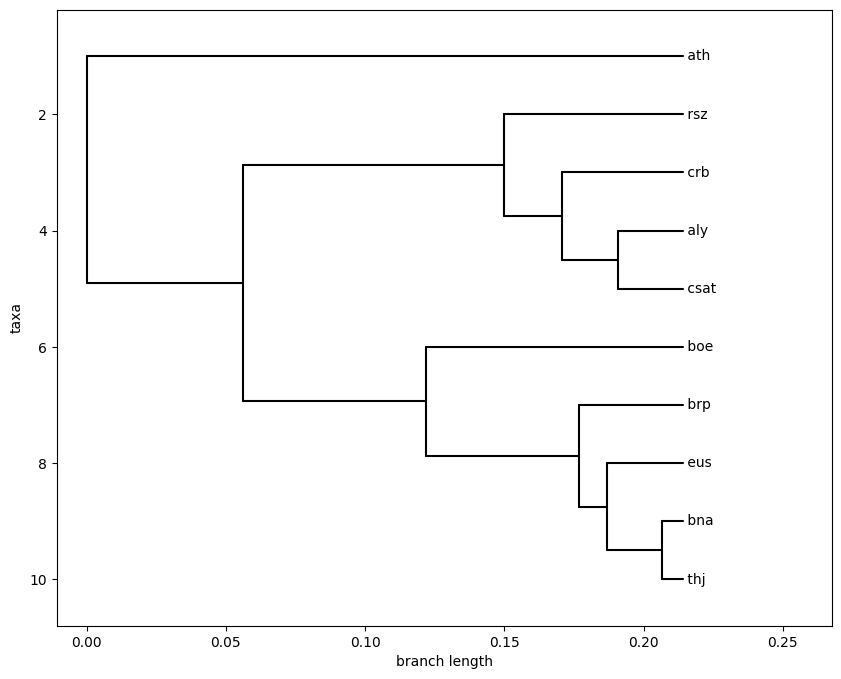

In [17]:
from Bio import Phylo
import io
import matplotlib.pyplot as plt

tree = Phylo.read(io.StringIO(newick_nt), "newick")
# Отображение дерева
fig = plt.figure(figsize=(10, 8))
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

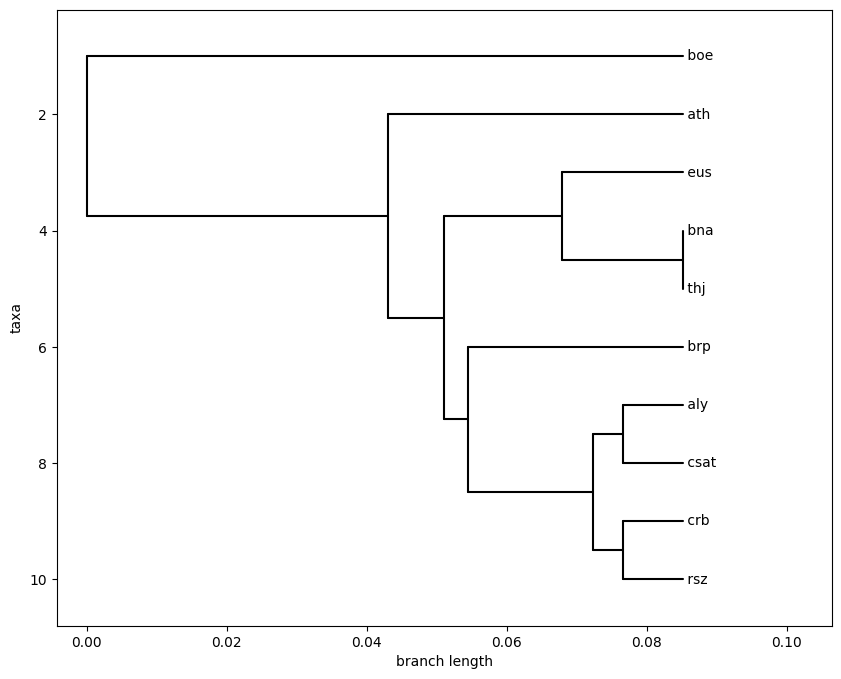

In [18]:
from Bio import Phylo
import io
import matplotlib.pyplot as plt

tree = Phylo.read(io.StringIO(newick_aa), "newick")
# Отображение дерева
fig = plt.figure(figsize=(10, 8))
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)